# Deep learning assessment

The following notebook develops and compares 2 CNN models which are able to clasfiffy images with a cell nuclei in the centre of the image into 4 categories:
 
1. Normal epithelial cell nuclei with label 0.
2. Cancer epithelial cell nuclei with label 1.
3. Muscle cell nuclei with label 2.
4. Immune leukocyte cell nuclei with label 3.

## Import dependecies


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from skimage import io, transform
import datetime
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torch.optim import lr_scheduler
import torchvision
from torchvision import models, datasets

from PIL import Image

import copy
import time
import os
import shutil

# For ray-tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
from torch.utils.data import random_split

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

# Input data files are available in the read-only "../input/" director

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Set the seed

The seed is set for torch, numpy and python so that it is fully repeatable

In [5]:
np.random.seed(seed=0)
torch.manual_seed(0)
random.seed(0)

path_to_dir = "kaggle/input/deep-learning-for-msc-2022-23/train.csv"

## Inspect the data

The data provided consists of a set of 100x100 pixel images with coresponding csv files provided the labels. There are 7560 training samples and 5041 testing samples. A pandas dataframe is created with the fields `'Filename'` and `'Label'`.

In [6]:
train_data = pd.read_csv('kaggle/input/deep-learning-for-msc-2022-23/train.csv')
print(f'Data contains: {len(train_data)} samples')
print(train_data.head())

Data contains: 7560 samples
  Filename  Label
0    1.png      0
1    2.png      0
2    3.png      0
3    4.png      0
4    5.png      0


## Display image

A helper function is made to display images with the coresponding label.

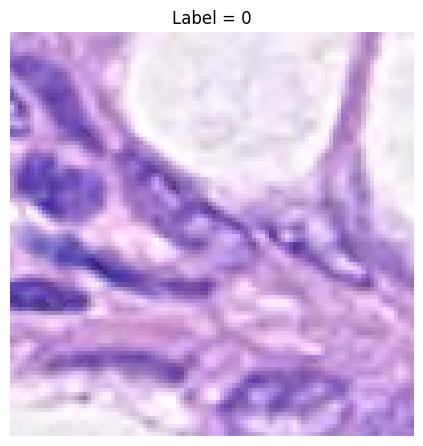

In [7]:
def show_Label(image,Label):
    """Show image with Label"""
    plt.imshow(image)
    plt.title(f'Label = {Label}')
    plt.tight_layout()
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated

img_name = train_data['Filename'].iloc[0]
Label = train_data['Label'].iloc[0]

plt.figure()
show_Label(io.imread(os.path.join('kaggle/input/deep-learning-for-msc-2022-23/train/', img_name)), Label)
plt.show()

## Dataset class

A custom dataset class is created which inherits from the ``torch.utils.data.Dataset`` class and overides the following methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can be used to get $i^{th}$ sample.

The csv is read in the ``__init__`` but leaves reading of images to
``__getitem__`` which is memory efficient as not all images are stored in the memory but rather read as required.

The sample of the dataset will be a dict ``{'image': image, 'Label': Label}``


The dataset will also take an optional argument ``transform`` so that any required processing can be
applied on the sample as well as and id array that is used to split the test and train datasets.

In [8]:
class labeledDataset(Dataset):
    """Face Label dataset."""

    def __init__(self, csv_file, root_dir,ids, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        df = pd.read_csv(csv_file)
        self.imgs = df.iloc[ids,:]
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.imgs['Filename'].iloc[idx])

        image = Image.open(img_name)
        Label = self.imgs['Label'].iloc[idx]
        
        if self.transform:
            image = self.transform(image)
            Label = torch.tensor(Label)
        
        sample = {'image': image, 'Label': Label}

        # if self.transform:
        #     sample = self.transform(sample)

        return sample

## Constructing datasets
2 datasets are constructed:
- training set
- test set

**Data augmentation** is used in the training set to provide more variation within the set. This is done using `torchvision.transforms` package. The images are first converted to tensors then resized and finaly a random crop is applied.

The `torch.utils.data.DataLoader` is then used to load the data. A train and test loader are constructed where train set has a batch size of 4 and train loader with batch size of 1 as it is only used for validation.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Generate IDs for train-test split
train_ids, test_ids = train_test_split(np.arange(0,7560),test_size=0.2,train_size=0.8)

ids = {}
ids['train'] = train_ids
ids['val'] = test_ids

image_datasets = {x: labeledDataset(csv_file=r'kaggle\input\deep-learning-for-msc-2022-23\train.csv',
                                    root_dir=r'kaggle\input\deep-learning-for-msc-2022-23\train',
                                    ids = ids[x],transform=data_transforms[x])
                                for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [0,1,2,3]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Helper function to show a batch
def show_batch(sample_batched):
    """Show image with Label for a batch of samples."""
    images_batch, Label_batch = \
            sample_batched['image'], sample_batched['Label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from train_loader')
    
if __name__ == '__main__':
    for i_batch, sample_batched in enumerate(dataloaders['train']):
        print(i_batch, sample_batched['image'].size(),
            sample_batched['Label'].size())

        # observe 4th batch and stop.
        if i_batch == 3:
            plt.figure()
            show_batch(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break

## Build the networks

Both models used are CNNs. The first is constructed using 2 2D convolutional layrs with kernel size of 3 and the secodnd is based on imageNet.

This is all from lab 3 which discusses how to build a convolutional neural network.

64(channels)x64x64(img dimensions)/4(max pooling) = 65536

whish is used in the linear layer

In [ ]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    ## training, test losses and acuracy are stored in a list for later plotting
    losses = {'train':  [], 'test': []}
    accs = {'train':  [], 'test': []}
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for item in dataloaders[phase]:
                inputs = item['image']
                labels = item['Label']
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return losses,accs, model

## Function to visualise confusion matrix

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                io.imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
## Custom model
class Net(nn.Module):
    def __init__(self, l1=120, l2=60):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,20,3,padding=1)
        self.conv2 = nn.Conv2d(20, 30, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear((64*64*30)//16, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 4)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
model = Net()


## Model initialised with resnet weights
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()


criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
losses_ft, accs_ft, model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
losses, accs, model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model, num_images=6)

In [ ]:
visualize_model(model_ft, num_images=6)

In [ ]:

def plot_losses(losses,losses_ft,mode):
    plt.title(f'{mode}ing loss')
    plt.plot(losses_ft['train'],label='Finetuned model')
    plt.plot(losses['train'],label= 'custom CNN model')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    
def plot_accuracy(accs,accs_ft,mode):
    plt.title(f'{mode}ing accuracy')
    plt.plot(accs_ft['train'],label='Finetuned model')
    plt.plot(accs['train'],label= 'custom CNN model')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    
plt.figure(1)
plot_losses(losses,losses_ft,'train')

plt.figure(2)
plot_losses(losses,losses_ft,'test')

plt.figure(3)
plot_accuracy(accs,accs_ft,'train')

plt.figure(4)
plot_accuracy(accs,accs_ft,'test')

NameError: name 'plt' is not defined

## Using Captum

In [ ]:
df = example_data = pd.read_csv(path_to_dir)

idx_to_labels = df['Label']

img = Image.open(r'kaggle\input\deep-learning-for-msc-2022-23\train\1.png')

img

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

transformed_img = transform(img)

input = transform_normalize(transformed_img)

input = input.unsqueeze(0)


In [ ]:
output = model_ft(input)

output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()

predicted_label = idx_to_labels[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


In [ ]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)



In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)


In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:


gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:


val_dataset  = labeledDataset(csv_file=r'kaggle\input\deep-learning-for-msc-2022-23\example.csv',
                                           root_dir=r'kaggle\input\deep-learning-for-msc-2022-23\test',
                                           ids = np.arange(0,5040))

val_loader = DataLoader(val_dataset, batch_size=1,
                        shuffle=False, num_workers=0)


filenames = pd.read_csv("kaggle/input/deep-learning-for-msc-2022-23/example.csv")

filenames = filenames['Filename']

names = []
preds = []

for idx, item in enumerate(val_loader):
    img_name = filenames[idx]
    imgs=item['image']
    labels = item['Label']
    imgs = imgs.to(device)
    output = model_ft(imgs)
    pred = output.argmax(dim=1, keepdim=True)
    
    preds.append(pred.numpy()[0][0])
    names.append(img_name)
    


# print(f'The predicted label is{preds.numpy()[0][0]}')

data = {'Filename': names, 'Label': preds}

df = pd.DataFrame(data)

df.to_csv('submission.csv',index=False)